In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [28]:
import os
import datetime
import re
import json
import cProfile
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import ray
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
import geopandas as geopd
import pandas as pd
import querier as qr
from dotenv import load_dotenv
load_dotenv()

import ses_ling.utils.geometry as geo_utils
import ses_ling.data.access as data_access
import ses_ling.data.filter as data_filter
import ses_ling.data.user_residence as user_residence
import ses_ling.utils.paths as path_utils
import ses_ling.utils.spatial_agg as spatial_agg
from ses_ling.language import Language
from ses_ling.region import Region

In [29]:
paths = path_utils.ProjectPaths()

In [30]:
with open(paths.countries_dict) as f:
    countries_dict = json.load(f)
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [57]:
cc = 'GB'
cc_dict = countries_dict[cc]
xy_proj = cc_dict['xy_proj']
year_from = 2015
year_to = 2021
colls = cc_dict['mongo_coll']
timezone = cc_dict['timezone']
assign_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
    gps_dups_th=100,
    pois_dups_th=500,
)
paths.partial_format(cc=cc, year_from=year_from, year_to=year_to, **cc_dict, **assign_kwargs)

In [32]:
_cc_init_params = {
    cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "IMD", "res_cell_size": "MSOA_BGC"}
}
lang = Language(
    'en', 'English', _cc_init_params, countries_dict,
    all_cntr_shapes=all_cntr_shapes,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15, # this might cause init pb because of setter
    res_attr_kwargs=assign_kwargs,
)
r = lang.regions[0]

shape_geodf loaded for GB
ses_df loaded for GB
cell_levels_corr loaded for GB
lt_rules loaded for GB
regions done
done


# Deprivation index

In [5]:
from libpysal.weights import Rook
from spopt.region import WardSpatial
from sklearn.cluster import AgglomerativeClustering

## Wales

THese are ranks! So averaging or inter-lsoa comparisons make no sense!

In [ ]:
zip_fpaths = list((paths.ext_data / 'wimd2014').glob('*.zip'))
# put overall first because different format, simply more practical and more logical
zip_fpaths.sort(key=lambda p: 'overall' not in p.stem)
wimd = geopd.GeoDataFrame.from_file(zip_fpaths[0]).set_index('2014_lsoa')
for zipf in zip_fpaths[1:]:
    part = geopd.GeoDataFrame.from_file(zipf).set_index('2014_lsoa')
    part_var = zipf.stem.split('_')[-1]
    var_col_mask = part.columns.str.startswith('2014_')# | part.columns.str.endswith('_2014')
    var_col = part.columns[var_col_mask][0]
    wimd = wimd.join(part.loc[:, var_col].rename(f'2014_{part_var}'))
wimd.to_file(paths.interim_data / 'wimd2014' / 'wimd2014.shp')

In [ ]:
wimd = geopd.read_file(paths.interim_data / 'wimd2014' / 'wimd2014.shp')

In [ ]:
wimd.head()

,2014_lsoa,lsoa11cd,lsoa11nm,wimd_2014,decile,map_group,2014_healt,2014_envir,2014_servi,2014_housi,2014_incom,2014_safet,2014_educa,2014_emplo,geometry
0,W01001546,W01001546,Monmouthshire 002A,403.0,3.0,30% Most Deprived,714.0,1220.0,1342.0,498.0,240.0,387.0,315.0,417.0,"POLYGON ((329425.970 214538.497, 329425.094 21..."
1,W01001545,W01001545,Monmouthshire 001A,1687.0,9.0,50% Least Deprived,1043.0,889.0,1291.0,1769.0,1599.0,1752.0,1884.0,1374.0,"POLYGON ((328804.667 214649.107, 328800.406 21..."
2,W01001542,W01001542,Monmouthshire 009A,1472.0,8.0,50% Least Deprived,1491.0,1398.0,222.0,1536.0,1434.0,1622.0,1730.0,1357.0,"POLYGON ((349359.166 191300.821, 349353.051 19..."
3,W01000088,W01000088,Gwynedd 007B,1276.0,7.0,50% Least Deprived,1461.0,1395.0,200.0,957.0,1276.0,1446.0,1288.0,1304.0,"POLYGON ((248431.557 356977.100, 248420.703 35..."
4,W01001543,W01001543,Monmouthshire 009B,1804.0,10.0,50% Least Deprived,1879.0,608.0,1353.0,1881.0,1716.0,1515.0,1573.0,1729.0,"POLYGON ((347827.977 189358.129, 347860.644 18..."


In [ ]:
metric_col = '2014_incom'

In [ ]:
wimd[metric_col].describe()

count    1909.000000
mean      955.000000
std       551.225151
min         1.000000
25%       478.000000
50%       955.000000
75%      1432.000000
max      1909.000000
Name: 2014_incom, dtype: float64

In [ ]:
wimd.plot(column=metric_col)

In [ ]:
w = Rook.from_dataframe(wimd)

In [ ]:
model = AgglomerativeClustering(
    n_clusters=None,
    connectivity=w.sparse,
    linkage="complete",
    distance_threshold=100,
    affinity='l1',
)
model.fit(wimd[[metric_col]].values)
# model = WardSpatial(wimd, w, [metric_col], n_clusters=None, clustering_kwds={'distance_threshold': 200})
# model.solve()
wimd['labels'] = model.labels_

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:549: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.



In [ ]:
clustered_wimd = wimd[['labels', 'geometry']].dissolve(by='labels')
# weighted average (by pop) instead of normal one?
clustered_wimd = clustered_wimd[['geometry']].join(wimd.groupby('labels').agg(**{k: (metric_col, k) for k in ['mean', 'min', 'max', 'size']}))

In [177]:
clustered_wimd.explore('mean')

NameError: name 'clustered_wimd' is not defined

## England

In [7]:
file_prefix = 'Indices_of_Multiple_Deprivation_(IMD)_2019'
imd = geopd.read_file(paths.ext_data / f'{file_prefix}' / f'{file_prefix}.shp').set_index('lsoa11cd')
imd.shape

(32844, 66)

In [ ]:
imd.columns

Index(['FID', 'lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60_', 'WorkPop', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [8]:
metric_col = 'EduScore'

In [9]:
imd[[metric_col]].to_parquet('mdr.parquet')

In [8]:
imd[metric_col].describe()

count    32844.000000
mean        21.691084
std         18.607562
min          0.013000
25%          7.360000
50%         16.180500
75%         30.906500
max         99.446000
Name: EduScore, dtype: float64

In [ ]:
imd['TotPop'].describe()

count    32844.000000
mean      1666.307514
std        363.622458
min        523.000000
25%       1446.000000
50%       1598.000000
75%       1800.000000
max       9551.000000
Name: TotPop, dtype: float64

### Aggregate into MSOA

In [9]:
base_name = 'infuse_msoa_lyr_2011_clipped'
msoa = geopd.read_file(paths.ext_data / base_name / f'{base_name}.shp').set_index('geo_code').rename_axis('msoa_id')
print(msoa.shape)

(8480, 3)


In [277]:
lsoa_to_msoa = pd.read_csv(paths.ext_data / 'Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District__December_2020__Lookup_in_England_and_Wales.csv')
lsoa_to_msoa.columns = lsoa_to_msoa.columns.str.lower()
cols_mask = lsoa_to_msoa.columns.str.match(r'(l|m)soa.+cd')
lsoa_to_msoa = lsoa_to_msoa.loc[:, cols_mask].drop_duplicates().set_index('lsoa11cd')
lsoa_to_msoa.columns = lsoa_to_msoa.columns.str.slice_replace(4, None, '_id')
lsoa_to_msoa.head()

,msoa_id
lsoa11cd,
E01011969,E02002483
E01011949,E02002491
E01011970,E02002483
E01011971,E02002483
E01011950,E02002490


In [11]:
imd = imd.join(lsoa_to_msoa, how='left')

In [12]:
grouper = imd.groupby('msoa_id')
imd['msoa_pop'] = grouper['TotPop'].transform('sum')
imd['wavg_elem'] = imd[metric_col] * imd['TotPop'] / imd['msoa_pop']
imd['avg'] = grouper[metric_col].transform('mean')
imd['wvar_elem'] = (imd[metric_col] - imd['avg'])**2 * imd['TotPop'] / imd['msoa_pop']
msoa_imd = grouper.agg(
    wavg=('wavg_elem', 'sum'),
    wvar=('wvar_elem', 'mean'),
    avg=('avg', 'first'),
    var=(metric_col, 'var'),
    min=(metric_col, 'min'),
    max=(metric_col, 'max'),
    pop=('msoa_pop', 'first'),
)
msoa_imd['wstd'] = np.sqrt(msoa_imd['wvar'])

In [13]:
msoa_imd

,wavg,wvar,avg,var,min,max,pop,wstd
msoa_id,,,,,,,,
E02000001,0.909384,10.202581,5.36350,72.967058,0.024,22.260,6687,3.194148
E02000002,7.778841,19.246909,30.48075,102.333271,17.349,38.753,7379,4.387130
E02000003,2.976738,2.308306,17.61100,17.342949,12.848,23.035,10720,1.519311
E02000004,5.729982,9.018080,23.15025,51.392207,18.702,33.858,6536,3.003012
E02000005,5.404532,8.729057,27.56860,51.124119,19.124,37.624,9243,2.954498
...,...,...,...,...,...,...,...,...
E02006930,1.583553,3.187740,6.79025,19.861708,3.229,13.311,7537,1.785424
E02006931,1.303344,3.254671,6.18140,19.642651,1.047,12.399,9405,1.804071
E02006932,5.488467,44.602976,22.97760,237.947663,4.158,43.037,12651,6.678546


In [13]:
msoa_imd['wstd'].describe()

count    6791.000000
mean        3.661148
std         2.536428
min         0.000000
25%         1.701512
50%         3.064247
75%         5.094203
max        18.475722
Name: wstd, dtype: float64

In [15]:
# checked min and max in 2015 edition of https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates
msoa_imd['pop'].describe()

count     6791.000000
mean      8058.931527
std       1772.452425
min       2335.000000
25%       6722.000000
50%       7834.000000
75%       9064.500000
max      18534.000000
Name: pop, dtype: float64

In [15]:
msoa_gdf = msoa.join(msoa_imd, how='inner')

In [58]:
simplified_mgeoms = msoa_gdf.geometry.simplify(50).to_crs('epsg:4326').rename('geometry')

In [ ]:
plot_gdf = geopd.GeoDataFrame(msoa_imd.join(simplified_mgeoms, how='inner'))

In [ ]:
m = plot_gdf.explore('wstd')

In [ ]:
m.save(paths.figs / 'imd_msoa.html')

In [17]:
msoa_gdf.shape

(6791, 11)

### Spatial aggregate by hand

In [436]:
w = Rook.from_dataframe(imd)

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 2 islands with ids: 18535, 26052.
  warnings.warn(message)


In [232]:
comp_ids, comp_inv, comp_counts = np.unique(w.component_labels, return_inverse=True, return_counts=True)
biggest_comp = comp_ids[comp_counts.argmax()]
idc_biggest_comp = np.nonzero(w.component_labels == biggest_comp)

In [82]:
full_w = w.full()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [84]:
# comp_w = full_w[idc_biggest_comp[:, np.newaxis], idc_biggest_comp]
comp_w = full_w[idc_biggest_comp, idc_biggest_comp[0]]

In [85]:
comp_w.shape

(32650, 32650)

In [174]:
from scipy import sparse
connectivity = sparse.lil_matrix(comp_w)

when two clusters are merged, need to add to the heap `inertia` and structure matrix `A` the distances not calcuated before between unconnected points. But can't edit heap, and checking every time you pop defeats the purpose of a heapq. Nah but just have to push the right distance on L243. This implies either filling A with all pairwise distances or alculating them on the fly

In [408]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

rng = np.random.RandomState(0)
n_samples = 100
conn = np.ones([n_samples, n_samples], dtype=bool)
# Add some random sparsity, 70% at most
masked = (rng.random((n_samples, 70)) * n_samples).astype(int)
for i, nbh in enumerate(masked):
    conn[i, nbh] = False
    conn[nbh, i] = False
X = rng.randn(n_samples, 1)
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=1,
    connectivity=conn,
    linkage='complete',
    affinity='l1',
)
clustering.fit(X)
df = pd.DataFrame({'labels': clustering.labels_, 'x': X.flatten()})
clustered_df = df.groupby('labels').agg(**{op: ('x', op) for op in ['min', 'max']})
# This should be < distance_threshold
print((clustered_df['max'] - clustered_df['min']).max())

1.20248995732655


In [437]:
connectivity = w.sparse
idc_biggest_comp = (np.arange(imd.shape[0]), )
model = AgglomerativeClustering(
    n_clusters=None,
    connectivity=connectivity,
    linkage="complete",
    distance_threshold=5,
    affinity='l1',
)
model.fit(imd[[metric_col]].values[idc_biggest_comp])
# model = WardSpatial(wimd, w, [metric_col], n_clusters=None, clustering_kwds={'distance_threshold': 200})
# model.solve()
# imd['labels'] = model.labels_

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:549: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(affinity='l1',
                        connectivity=<32844x32844 sparse matrix of type '<class 'numpy.float64'>'
	with 189220 stored elements in Compressed Sparse Row format>,
                        distance_threshold=5, linkage='complete',
                        n_clusters=None)

In [446]:
comp_imd = imd.iloc[idc_biggest_comp[0]].copy()
comp_imd['labels'] = model.labels_

In [448]:
clustered_imd = comp_imd.groupby('labels').agg(**{k: (metric_col, k) for k in ['mean', 'min', 'max', 'size']})
print((clustered_imd['max'] - clustered_imd['min']).max())
print(clustered_imd.shape, comp_imd.shape)

24.389
(12198, 4) (32844, 68)


when connectivity, distance is not direct but through "path" has to take to join originally disconnected nodes, which fro complete linkage should be highes tdistance along this path

all following is consistent, so problem is actual values of distances

In [240]:
mask_pb_label = comp_imd['labels'] == clustered_imd.index[(clustered_imd['max'] - clustered_imd['min']).argmax()]
idc_pb = np.nonzero(mask_pb_label.values)

In [250]:
max_d = 0
max_i = 0
for i in idc_pb[0]:
    mask = comp_w[idc_pb[0], i].astype(bool)
    values_in_nb = comp_imd[metric_col].iloc[idc_pb[0][mask]]
    d = values_in_nb.max() - values_in_nb.min()
    if d > max_d:
        max_d = d
        max_i = i
max_d

7.823999999999999

In [252]:
mask = comp_w[idc_pb[0], max_i].astype(bool)
values_in_nb = comp_imd[metric_col].iloc[idc_pb[0][mask]]

In [256]:
comp_imd.iloc[[4075, 4085, 5099]][['labels', metric_col]]

,labels,EduScore
4075,251,14.854
4085,251,7.030
5099,251,13.722


In [253]:
values_in_nb

4075    14.854
4085     7.030
5099    13.722
Name: EduScore, dtype: float64

In [249]:
comp_imd[metric_col].iloc[idc_pb[0][mask]]

11217    1.076
11238    1.270
11851    3.356
32085    3.708
Name: EduScore, dtype: float64

In [199]:
clustered_imd.iloc[223]

mean     6.808525
min      2.884000
max     11.566000
size    59.000000
Name: 223, dtype: float64

In [450]:
clustered_imd = comp_imd[['labels', 'geometry']].dissolve(by='labels').join(clustered_imd)
# weighted average (by pop) instead of normal one?

In [452]:
map = clustered_imd.explore('mean')

In [453]:
map.save(paths.figs / 'agg_lsoa.html')

# Attribution

In [10]:
res_cell_size = 'MSOA_BGC'
cell_shp_metadata = cc_dict['cell_shapefiles'][res_cell_size]
kind = cell_shp_metadata['kind']
cell_col = cell_shp_metadata['index_col']
subcell_level = 'LSOA_BGC'
subcell_shp_metadata = cc_dict['cell_shapefiles'][subcell_level]
subcell_col = subcell_shp_metadata['index_col']

In [70]:
subcell_shp_metadata

{'fname': 'Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3',
 'index_col': 'LSOA11CD',
 'kind': 'census'}

In [58]:

res_cell_size = 'MSOA_BGC'
gps_attr_level = 'LSOA_BGC'
gps_dups_th = 500
pois_dups_th = 500

res_attr_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
    gps_dups_th=gps_dups_th,
    pois_dups_th=pois_dups_th,
)

reg = Region(
    cc, 'en', cc_dict, res_cell_size, cell_size=res_cell_size,
    year_from=year_from, year_to=year_to,
    res_attr_kwargs=res_attr_kwargs,
)

shape_geodf loaded for GB
ses_df loaded for GB
cell_levels_corr loaded for GB
lt_rules loaded for GB


In [61]:
cell_shp_metadata = reg.cell_shapefiles[reg.res_cell_size]
cell_col = cell_shp_metadata['index_col']
subcell_shp_metadata = reg.cell_shapefiles[gps_attr_level]
subcell_col = subcell_shp_metadata['index_col']
spatial_agg.levels_corr(
    reg.cell_levels_corr, subcell_col, cell_col
)

Empty DataFrame
Columns: []
Index: [(E02000001, E01000001), (E02000001, E01000002), (E02000001, E01000003), (E02000001, E01000005), (E02000001, E01032739), (E02000001, E01032740), (E02000002, E01000027), (E02000002, E01000028), (E02000002, E01000029), (E02000002, E01000030), (E02000003, E01000031), (E02000003, E01000032), (E02000003, E01000110), (E02000003, E01000111), (E02000003, E01000112), (E02000003, E01000113), (E02000004, E01000034), (E02000004, E01000037), (E02000004, E01000038), (E02000004, E01000039), (E02000005, E01000063), (E02000005, E01000100), (E02000005, E01000101), (E02000005, E01000109), (E02000005, E01000114), (E02000007, E01000033), (E02000007, E01000060), (E02000007, E01000061), (E02000007, E01000062), (E02000007, E01000064), (E02000008, E01000065), (E02000008, E01000078), (E02000008, E01000080), (E02000008, E01000081), (E02000008, E01000082), (E02000008, E01000083), (E02000008, E01000102), (E02000009, E01000021), (E02000009, E01000022), (E02000009, E01000023), (E02000009, E01000024), (E02000009, E01000025), (E02000009, E01000077), (E02000010, E01000015), (E02000010, E01000016), (E02000010, E01000017), (E02000010, E01000018), (E02000010, E01000079), (E02000011, E01000035), (E02000011, E01000036), (E02000011, E01000107), (E02000011, E01000108), (E02000012, E01000066), (E02000012, E01000067), (E02000012, E01000069), (E02000012, E01000070), (E02000012, E01000071), (E02000013, E01000057), (E02000013, E01000073), (E02000013, E01000074), (E02000013, E01000075), (E02000013, E01000076), (E02000014, E01000013), (E02000014, E01000014), (E02000014, E01000059), (E02000014, E01000084), (E02000014, E01000085), (E02000014, E01000086), (E02000015, E01000103), (E02000015, E01000104), (E02000015, E01000105), (E02000015, E01000106), (E02000016, E01000007), (E02000016, E01000008), (E02000016, E01000010), (E02000016, E01000012), (E02000017, E01000006), (E02000017, E01000009), (E02000017, E01000011), (E02000017, E01000044), (E02000017, E01000068), (E02000018, E01000041), (E02000018, E01000042), (E02000018, E01000045), (E02000018, E01000046), (E02000018, E01000072), (E02000019, E01000054), (E02000019, E01000055), (E02000019, E01000056), (E02000019, E01000058), (E02000019, E01000095), (E02000020, E01000040), (E02000020, E01000043), (E02000020, E01000050), (E02000020, E01000052), (E02000020, E01000092), (E02000021, E01000053), (E02000021, E01000087), (E02000021, E01000088), (E02000021, E01000089), ...]

[34753 rows x 0 columns]

In [64]:
str(reg.paths.user_cells_from_gps)

'/home/thomaslouf/Documents/code/ses-ling/data/interim/GB/user_cells_from_gps_{cell_kind}_2015-2021_gps_dups_th=500.parquet'

## Get places to cells matching

In [19]:
places_filter = qr.Filter().equals('country_code', cc)
tweets_filter = qr.Filter().not_exists('coordinates.coordinates')
places_gdf = data_access.agg_places_from_mongo(
    year_from, year_to, places_filter, tweets_colls=colls, tweets_filter=tweets_filter
)

134685it [00:12, 11009.96it/s]


In [ ]:
places_to_cells = user_residence.places_to_cells(
    places_gdf, lang.cells_geodf, xy_proj=cc_dict['xy_proj'], ntop=2,
    top_cells_cumoverlap_th=0.9, reg_overlap_th=0.6
)
places_to_cells.head()

ratio
id               msoa11cd          
0001878dda20c9d3 W02000108  0.93531
                 W02000110  0.06469
000543740a1a65b5 E02005514  1.00000
0008ac25d92c0023 E02006111  1.00000
000ab548b8bc815c E02006640  1.00000

## Load user counts per cell and place

In [17]:
user_places_counts = pd.read_parquet(paths.user_places)
user_places_counts.head()

count
user_id                                            place_id         is_daytime       
000003962867f2d312d942838cdb2535b950589f2e85f31... 01c7ed8caf11e8b2 False         1.0
                                                                    True          1.0
                                                   151b9e91272233d1 True          1.0
                                                   315b740b108481f6 False       245.0
                                                                    True        136.0

In [432]:
poi_counts = pd.DataFrame()
for year in range(year_from, year_to + 1):
    poi_counts = poi_counts.add(
        pd.read_parquet(paths.interim_data / cc / f"poi_counts_{year}.parquet"),
        fill_value=0,
    )

In [441]:
pois_dups_th = 500
user_places_counts = user_places_counts.join(
    poi_counts.loc[poi_counts['count'] < pois_dups_th, []],
    how='inner',
)

In [18]:
lang.res_attr_kwargs['gps_dups_th'] = 100
subcells_user_counts_from_gps = pd.read_parquet(
    str(lang.paths.user_cells_from_gps).format(
        cc=cc, gps_attr_cell_size=subcell_level,
    )
)
subcells_user_counts_from_gps.head()

count
user_id                                            lsoa11cd  is_daytime       
000003962867f2d312d942838cdb2535b950589f2e85f31... E01002828 True            1
                                                   E01002862 False           1
                                                   E01004736 True            1
                                                   E01004761 False           1
                                                   E01005209 True            1

In [508]:
subcells_to_cells = pd.read_csv(paths.ext_data / cc_dict['cell_levels_corr_files'][kind])
subcells_to_cells = spatial_agg.levels_corr(
    subcells_to_cells, subcell_col, cell_col
)
subcells_to_cells.head()
# [[subcell_col, cell_col]].drop_duplicates().set_index(subcell_col)[cell_col]

Empty DataFrame
Columns: []
Index: [(E02000001, E01000001), (E02000001, E01000002), (E02000001, E01000003), (E02000001, E01000005), (E02000001, E01032739)]

In [549]:
user_acty = user_residence.get_cell_user_activity(
    user_places_counts, places_to_cells, subcells_user_counts_from_gps, subcells_to_cells
)

In [550]:
user_acty.head()

count  \
user_id                                            msoa11cd  is_daytime          
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True          1.0   
                                                   E02000590 False         1.0   
                                                   E02000977 False         1.0   
                                                             True          1.0   
                                                   E02001063 True          1.0   

                                                                         prop_user  \
user_id                                            msoa11cd  is_daytime              
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True         0.035714   
                                                   E02000590 False        0.035714   
                                                   E02000977 False        0.035714   
                                                             True         0.035714   
                                                   E02001063 True         0.035714   

                                                                         prop_user_by_time  
user_id                                            msoa11cd  is_daytime                     
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True                    0.050  
                                                   E02000590 False                   0.125  
                                                   E02000977 False                   0.125  
                                                             True                    0.050  
                                                   E02001063 True                    0.050

In [551]:
user_residence_cell = user_residence.assign(
    user_acty, **{
        k: v for k, v in assign_kwargs.items()
        if k in ['nighttime_acty_th', 'all_acty_th', 'count_th']
    }
)

In [552]:
user_residence_cell

,msoa11cd,count,prop_user,prop_user_by_time
user_id,,,,
db9d47de65f90dd247ff622b66f8021c514504bfe32a15d371c6e4f0d24405d6ce01345d0f0b25ef55562c123ba5900d3fea3fe2c4ca09a877b0eb437ff30df7,E02001570,3.0,0.375000,1.000000
bdfc5e64ecbb98541359065c88f33961ba2ac75d551b3abb2e4b9501bbbb4e9ca95e3c0fcd95a29e6bbf3ceb48156c0661b30331f96391820f0efeb9caaede02,E02000972,3.0,0.333333,0.600000
71f091f4c8e850df1302eccdd4c2954a5fd30198e7115a06c2622af34d687d1c7a433235b4b27deb8d12c5161ea4455e43bc79f3722e13093aa93271b094d757,E02002218,3.0,0.428571,0.600000
4f11afdbc9960728b66b1385af1689c3e1d14ad7a4b1d822ec7012356b89f317c7cb56fac4e9bea1f013eace9b8a58e109a2cd1ae7a9baacd38c2db04ec8a628,E02005269,3.0,0.272727,1.000000
71f3fa671bd0f2283dd809576718b61a0d84c79963e9acb562251e5d619c2c56dba5ae51eaa061d69f820d44602ebd387fb94f5ee2f67f5c16ea64654a09ddbe,E02000925,3.0,0.500000,1.000000
...,...,...,...,...
7d2b791ddbd8efad65dd860859432b17deadf669d878f878826eadfcd7a5db278ec28575ff19905350ed319a5ceb1faf0d9502a0314452465317aefd71157bc8,E02006931,10102.0,0.817182,0.984025
f78bc2d165c4e7567100cdf42b97e568895c7c0ab534ba3d25676fea63b33c2fac298b491f291353a96e8a7d3ce7e270f8befbe03f7d58556fed4903c893481b,E02003725,12124.0,0.410593,0.894628
58ab4683c11dcc2595c57b63100106615ff32caa3318f91f9a2248a8d96835ec0829956733f655df1a334d87f6ca251e0d5f10867ace1301aa5687d342299aa2,E02001333,22962.0,0.305476,0.537840


<AxesSubplot:ylabel='Count'>

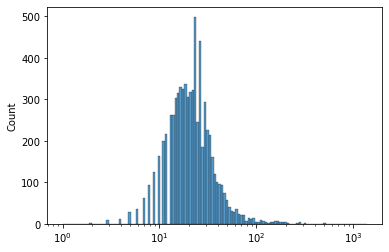

In [553]:
nr_users_per_cell = user_residence_cell.groupby('msoa11cd').size()
sns.histplot(nr_users_per_cell, log_scale=True)
# user_residence_cell.groupby('cell_id').size().plot(kind='hist')

In [556]:
user_residence_cell.to_parquet(
    str(lang.paths.user_residence_cell).format(cc=cc, res_cell_size=res_cell_size)
)

### PB

In [11]:
lang.user_residence_cell

,cell_id,count,prop_user,prop_user_by_time
user_id,,,,
db9d47de65f90dd247ff622b66f8021c514504bfe32a15d371c6e4f0d24405d6ce01345d0f0b25ef55562c123ba5900d3fea3fe2c4ca09a877b0eb437ff30df7,E02001570,3.0,0.375000,1.000000
bdfc5e64ecbb98541359065c88f33961ba2ac75d551b3abb2e4b9501bbbb4e9ca95e3c0fcd95a29e6bbf3ceb48156c0661b30331f96391820f0efeb9caaede02,E02000972,3.0,0.333333,0.600000
71f091f4c8e850df1302eccdd4c2954a5fd30198e7115a06c2622af34d687d1c7a433235b4b27deb8d12c5161ea4455e43bc79f3722e13093aa93271b094d757,E02002218,3.0,0.428571,0.600000
4f11afdbc9960728b66b1385af1689c3e1d14ad7a4b1d822ec7012356b89f317c7cb56fac4e9bea1f013eace9b8a58e109a2cd1ae7a9baacd38c2db04ec8a628,E02005269,3.0,0.272727,1.000000
71f3fa671bd0f2283dd809576718b61a0d84c79963e9acb562251e5d619c2c56dba5ae51eaa061d69f820d44602ebd387fb94f5ee2f67f5c16ea64654a09ddbe,E02000925,3.0,0.500000,1.000000
...,...,...,...,...
7d2b791ddbd8efad65dd860859432b17deadf669d878f878826eadfcd7a5db278ec28575ff19905350ed319a5ceb1faf0d9502a0314452465317aefd71157bc8,E02006931,10102.0,0.817182,0.984025
f78bc2d165c4e7567100cdf42b97e568895c7c0ab534ba3d25676fea63b33c2fac298b491f291353a96e8a7d3ce7e270f8befbe03f7d58556fed4903c893481b,E02003725,12124.0,0.410593,0.894628
58ab4683c11dcc2595c57b63100106615ff32caa3318f91f9a2248a8d96835ec0829956733f655df1a334d87f6ca251e0d5f10867ace1301aa5687d342299aa2,E02001333,22962.0,0.305476,0.537840


In [12]:
lang.user_df

,nr_tweets,nr_words,nr_unique_words,cell_id
user_id,,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731,NaN
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715,E02001640
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258,E02005173
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453,NaN
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233,NaN
...,...,...,...,...
ffe722f61fb277a9d093e4d3dbb4a693a8ae00fecd53527731d7d2394014876ba1e502071758a84444d85ced53aefd469188d6059d06eaac886975cacba11eb9,15,250,152,E02002692
ffe7d66852963f810b6bc8c4734daaaecf104f44b7356fdeac46725cc69f384a4cb1ab06c3e42e32969f2cf934ba7889a8a0afde81c5fce198ce85aeeb87b3c0,117,3146,1109,NaN
fff709781e95eb991005d304656fea10dbeee0e6f325650b22507aba47965554b37c6ce97b61b3980147ed4be5a58e071da0cd7e02e5c443f5a7a64679d592cf,37,277,167,E02006003


In [14]:
cells_nr_users_ordered = lang.cells_users_df['nr_users'].sort_values(ascending=False).index
lang.cells_geodf.loc[cells_nr_users_ordered].head()

,objectid,msoa11nm,msoa11nmw,bng_e,bng_n,long,lat,shape__are,shape__len,geometry
cell_id,,,,,,,,,,
E02000977,945,Westminster 018,Westminster 018,529421,180359,-0.13653,51.50735,2.516826e+06,12588.286983,"POLYGON ((530914.188 181358.203, 530977.999 18..."
E02000972,940,Westminster 013,Westminster 013,529173,181212,-0.13979,51.51507,1.289098e+06,7329.153863,"POLYGON ((528896.688 182258.641, 528891.032 18..."
E02001731,1684,Newcastle upon Tyne 024,Newcastle upon Tyne 024,424156,565269,-1.62410,54.98144,5.023788e+06,14237.030493,"POLYGON ((424812.864 565914.126, 424852.910 56..."
E02006875,6733,Leeds 111,Leeds 111,429871,433257,-1.54802,53.79478,2.518752e+06,8806.723275,"POLYGON ((431109.484 433569.999, 430977.276 43..."
W02000398,7177,Cardiff 032,Caerdydd 032,317962,176840,-3.18287,51.48454,2.369429e+06,7454.348107,"POLYGON ((317387.013 178090.733, 317535.644 17..."


In [15]:
pb_cell = cells_nr_users_ordered[0] # from lang.cells_users_df
# pb_cell = nr_users_per_cell.idxmax() # from new residence cell
lang.user_residence_cell.loc[lang.user_residence_cell['cell_id'] == pb_cell]

,cell_id,count,prop_user,prop_user_by_time
user_id,,,,
ee57795e9feeab6397314fd926cef0d3029946e00875eafe201aaa686f0162f48a66982853cc5423eb0dbef5611c1a0bf8babdc9630545451a3543c52a68b61e,E02000977,3.0,0.300000,0.600000
728e8343220763b01dd664932f6ca6d738d3ee3524c04558a453e24bfadd3beb8927fb95dcc66d6d0f9ad48d7f0221b5fc2d086230478f1ed8c58aec944a1d07,E02000977,3.0,0.600000,1.000000
eeabadd389139f3991425de1a4ba0116ce4d370e4ef715ba3e2505d5a774c579e842aaaa183b65f768f7424a8a7029abc05a2fc2f02a5d090c36a37748cd54a0,E02000977,3.0,0.600000,1.000000
e17ed74e40e4a608f929ab8e84a01c5aa5dd6faf4a1912f6562e5397192a13a41666fb3d12a3312b37e7ec3e8a30fafa89c23265ed945e7472aaaa2da3964c52,E02000977,3.0,0.136364,0.600000
eebd8b3f238ae28148dde5f5dda73c0fefb11de3d1a484f434c84b4ba4b2115bf968114e80fc7409823cb677ae43306445398ae7f2a983671b4b2d61e8cb3e9a,E02000977,3.0,0.500000,0.750000
...,...,...,...,...
a5bf6785927329cd6f751544ce846b89fe9142f65a4c9a776b05faed81797b6e0840486d77ebbbbd0321309ad07df218543dfbd8326e0d505455a06a4d7a682f,E02000977,652.0,0.571930,0.672165
ae3a951fab4619785dfbee0ad3412fad81811261507c12045fe0b86bb4264c1dc723a66ece1ef194295d810bcd900e91649d500a1014da016ece804074755bfd,E02000977,667.0,0.595536,0.736203
33b3287048e221576a43e3d0bbcf15335236da80dfa9f0892a54bc72b3065bca90bee22b992f59907083bb8ba0f00ef4c631b5f2f2a5920c0861f2149e9725cb,E02000977,987.0,0.695070,0.756322


In [16]:
pb_users = lang.user_residence_cell.loc[lang.user_residence_cell['cell_id'] == pb_cell].index

### problematic places

In [130]:
mask = (
    user_places_counts.index.isin(pb_users, level='user_id')
    & user_places_counts.index.isin(
        places_to_cells.loc[(slice(None), pb_cell), :].index.levels[0], level='place_id'
    )
)
pb_places = user_places_counts.loc[mask].loc[(slice(None), slice(None), False), :]

In [131]:
pb_places = (
    pb_places.join(
        places_to_cells.reset_index().set_index('id'), on='place_id', how='inner'
    ).groupby(['user_id', 'cell_id', 'is_daytime']).sum()
)
pb_places['count'] = pb_places['count'] * pb_places['ratio']
pb_places = pb_places.drop(columns='ratio') # .add(user_gps_counts, fill_value=0)
pb_places['prop_user'] = (
    pb_places['count']
    / pb_places.groupby('user_id')['count'].transform('sum')
)
pb_places['prop_user_by_time'] = (
    pb_places['count']
    / pb_places.groupby(['user_id', 'is_daytime'])['count'].transform('sum')
)

In [136]:
nighttime_acty_th=0.5
all_acty_th=0.1
count_th=3
nighttime_acty_mask = pb_places['prop_user_by_time'] >= nighttime_acty_th
all_acty_mask = pb_places['prop_user'] >= all_acty_th
count_th_mask = pb_places['count'] >= count_th
place_res = (
    pb_places.loc[nighttime_acty_mask & all_acty_mask & count_th_mask]
        .loc[(slice(None), slice(None), False)]
        .sort_values(by='count')
        .groupby('user_id')
        .tail(1)
        .reset_index().set_index('user_id') # ['cell_id']
)

In [138]:
place_res['count'].describe()

count     1018.000000
mean       111.085405
std       2717.267993
min          3.000000
25%          4.000000
50%          6.000000
75%         10.750000
max      86652.000000
Name: count, dtype: float64

#### Count POIs for exclusion

In [427]:
for year in range(2015, 2022):
    db = f'twitter_{year}'
    # f = data_access.gps_filter(qr.Filter())
    f = qr.Filter().not_exists('coordinates.coordinates').equals('place.place_type', 'poi')
    with qr.Connection(db) as con:
        grpby = con[coll].groupby('place.id', pre_filter=f, allowDiskUse=True)
        poi_counts = data_access.mongo_groupby_to_df(
            grpby, count=qr.NamedAgg('id', 'count')
        )
    poi_counts.to_parquet(paths.interim_data / cc / f"poi_counts_{year}.parquet")

: 

### Problematic GPS coords

In [416]:
pb_gps_counts = subcells_user_counts_from_gps.join(subcells_to_cells.loc[subcells_to_cells == pb_cell].rename_axis('cell_id'), how='inner')
pb_gps_counts = pb_gps_counts.loc[pb_gps_counts.index.isin(pb_users, level='user_id')].loc[(slice(None), slice(None), False), :]

In [417]:
pb_gps_counts = pb_gps_counts.reset_index().set_index(['user_id', 'MSOA11CD', 'is_daytime'])
pb_gps_counts['prop_user'] = (
    pb_gps_counts['count']
    / pb_gps_counts.groupby('user_id')['count'].transform('sum')
)
pb_gps_counts['prop_user_by_time'] = (
    pb_gps_counts['count']
    / pb_gps_counts.groupby(['user_id', 'is_daytime'])['count'].transform('sum')
)

In [418]:
nighttime_acty_th=0.5
all_acty_th=0.1
count_th=3
nighttime_acty_mask = pb_gps_counts['prop_user_by_time'] >= nighttime_acty_th
all_acty_mask = pb_gps_counts['prop_user'] >= all_acty_th
count_th_mask = pb_gps_counts['count'] >= count_th
gps_res = (
    pb_gps_counts.loc[nighttime_acty_mask & all_acty_mask & count_th_mask]
        .loc[(slice(None), slice(None), False)]
        .sort_values(by='count')
        .groupby('user_id')
        .tail(1)
        .reset_index().set_index('user_id') # ['cell_id']
)

In [419]:
gps_res

,MSOA11CD,cell_id,count,prop_user,prop_user_by_time
user_id,,,,,
7bc054c77c2cb3ac17c04b207c02eefca771e25655654560c1212bb63757af08e69df5976170d71fb024c925ca554d52c27079d1673b8b62019de50df351f665,E02000977,E01004735,3,1.000000,1.000000
34ff3f389a10fe303ce32775339c1d760d57b911eafc6ca004b51b8084f2ff3ec3e4bdf85089d42e08264cce212b179db218eb41af681b956b5a2e80edda70d3,E02000977,E01004735,3,1.000000,1.000000
357748d457ec7d1359efd62451bcfa799833b3f23d6d3719fd2834b2d5d4a0e0910f9cf51674948c806b5200d1b87ae94b023822de65500761a3cb5cfc126880,E02000977,E01004734,3,1.000000,1.000000
35d79c5a0f27c2478439f0c151bb0d83dde2023be13bd8d525d97c2c6db6fa8bf4dcaead009a6fcfd02e626ed776c37ab6990f4368841f39f3e8a9a304d1cc1a,E02000977,E01004734,3,1.000000,1.000000
cfb1de39dc1eea1c5e33a5cb9f6f39f1e13608c1c965d17a461092e194620457472a1fdb58f6c3245d5d7bf29d49981d25983e0a956082c2bd269334b76398e2,E02000977,E01004734,3,0.750000,0.750000
...,...,...,...,...,...
3df7c8818a0b67db9f0c2e8be15e40f649700edc4c16d96d27db878e6e469590885b86ea74ba674fae32e9a75215e593bfb2b7a1ac85ce4e7483a4f1244e0b5e,E02000977,E01004734,56,0.528302,0.528302
7e353af27792e4ec1f615c9038066dd70ad3d4a3cb90ddc749a21d77d3f1e505ef47d9a9a8f04c8aab4d1c8b36c33be8122d5a7dbabb3c62088b9e6ba2a105be,E02000977,E01004735,67,0.670000,0.670000
8dfe85b65ad31fbb5c4b1abce5b6db72dc28a5452abb0a053e92d4ad98194941e031c0a4b8cdc57cc077caaa627eca757741acbf85ba577ce87b1380f24db15c,E02000977,E01004736,69,0.932432,0.932432


apparently pb mostly in tweets with GPS, let's investigate some users

In [185]:
p = lang.cells_geodf.loc[[pb_cell], 'geometry'].to_crs('epsg:4326')
p.iloc[0].contains(Point(-0.127318,	51.507115))

True

In [201]:
tweets.loc[np.abs(tweets['x'] - (-0.127318)) < 1e-4, 'source'].unique()

<StringArray>
['<a href="http://instagram.com" rel="nofollow">Instagram</a>']
Length: 1, dtype: string

threshold on duplicate coordinates: like ~100-500 tweets from exact same place. first get distribution

In [221]:
db = 'twitter_2018'
# f = data_access.gps_filter(qr.Filter())
f = qr.Filter().not_exists('coordinates.coordinates').equal('place.place_type', 'poi')
with qr.Connection(db) as con:
    grpby = con[coll].groupby('place.id', pre_filter=f, allowDiskUse=True)
    counts = data_access.groupby_res_to_df(
        grpby.agg(count=qr.NamedAgg('id', 'count')), grpby.pipeline
    )

In [413]:
counts

,count
place_id,
0952a5b79d961000,1
0952b02f39d70001,1
0d8a52fb6d543006,3
0952961d75562004,4
63008eb4b4e61c8f,16564
...,...
0952a82b70170001,1
0952ace3f4562000,1
0952af93f5572000,1


In [230]:
poi_counts = counts.join(places_gdf.loc[places_gdf['place_type'] == 'poi', []], how='inner')

Text(0.5, 0, 'occurrences of same POI')

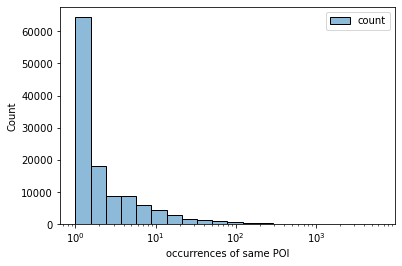

In [232]:
ax = sns.histplot(poi_counts, bins=20, log_scale=True)
ax.set_xlabel('occurrences of same POI')

Text(0.5, 0, 'occurrences of same POI')

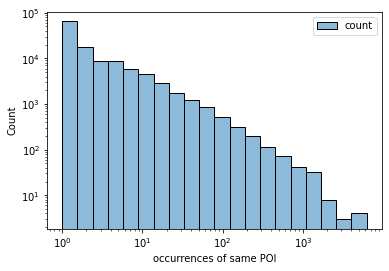

In [233]:
ax = sns.histplot(poi_counts, bins=20, log_scale=[True, True])
ax.set_xlabel('occurrences of same POI')

In [252]:
coords_counts['count'].sort_values().iloc[720000]

59

In [255]:
coords_counts.index[720000]

[1.243966, 52.66706]

Text(0.5, 0, 'occurrences of same GPS coordinates')

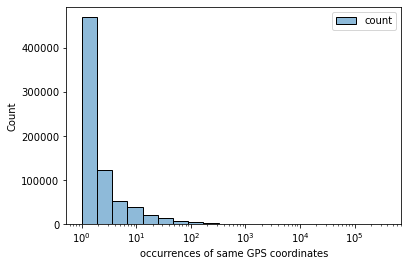

In [214]:
ax = sns.histplot(counts, bins=20, log_scale=True)
ax.set_xlabel('occurrences of same GPS coordinates')

Text(0.5, 0, 'occurrences of same GPS coordinates')

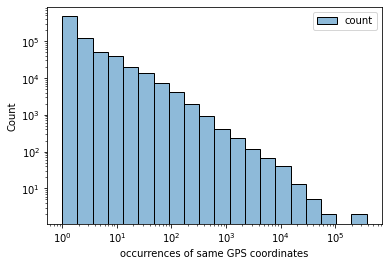

In [215]:
ax = sns.histplot(counts, bins=20, log_scale=[True, True])
ax.set_xlabel('occurrences of same GPS coordinates')

In [124]:
pb_gps_counts.head()

cell_id  \
user_id                                            MSOA11CD  is_daytime              
000062d7730263f5fbc68618a7826c9a63ff358028a29ba... E02000977 False       E01004736   
000362e8962e262467174bb9650b90c4d9b13099f97486c... E02000977 False       E01004735   
                                                             False       E01004736   
0005e3146d2c8c1826b565714af1efcc5a575febaf90990... E02000977 False       E01004736   
000691bdd3026fba6929822e485f0df10ce319ba130b4a4... E02000977 False       E01004736   

                                                                         count  \
user_id                                            MSOA11CD  is_daytime          
000062d7730263f5fbc68618a7826c9a63ff358028a29ba... E02000977 False         6.0   
000362e8962e262467174bb9650b90c4d9b13099f97486c... E02000977 False         1.0   
                                                             False         6.0   
0005e3146d2c8c1826b565714af1efcc5a575febaf90990... E02000977 False         6.0   
000691bdd3026fba6929822e485f0df10ce319ba130b4a4... E02000977 False         3.0   

                                                                         prop_user  \
user_id                                            MSOA11CD  is_daytime              
000062d7730263f5fbc68618a7826c9a63ff358028a29ba... E02000977 False        1.000000   
000362e8962e262467174bb9650b90c4d9b13099f97486c... E02000977 False        0.142857   
                                                             False        0.857143   
0005e3146d2c8c1826b565714af1efcc5a575febaf90990... E02000977 False        1.000000   
000691bdd3026fba6929822e485f0df10ce319ba130b4a4... E02000977 False        1.000000   

                                                                         prop_user_by_time  
user_id                                            MSOA11CD  is_daytime                     
000062d7730263f5fbc68618a7826c9a63ff358028a29ba... E02000977 False                1.000000  
000362e8962e262467174bb9650b90c4d9b13099f97486c... E02000977 False                0.142857  
                                                             False                0.857143  
0005e3146d2c8c1826b565714af1efcc5a575febaf90990... E02000977 False                1.000000  
000691bdd3026fba6929822e485f0df10ce319ba130b4a4... E02000977 False                1.000000

Text(0, 0.5, 'number of users')

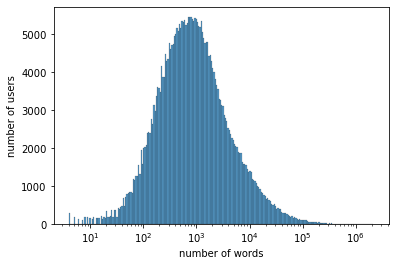

In [34]:
ax = sns.histplot(lang.user_corpora['nr_words'].rename('number of words'), log_scale=True)
ax.set_ylabel('number of users')